In [130]:
# ============================================================
# MP_2 — Imbalanced Classification (Mammography Dataset)
# Data Mining & Text Analytics — MATH 3310
#
# This script:
#   - Loads the Mammography dataset from an ARFF file
#   - Performs exploratory data analysis (EDA)
#   - Builds preprocessing and modeling pipelines
#   - Trains and evaluates multiple Random Forest–based models
#   - Uses different cross-validation strategies
#   - Applies class weights, SMOTE, and random undersampling
#   - Compares models using accuracy, balanced accuracy, F1, and G-mean
#   - Examines feature importance with impurity, permutation, and SHAP
#
# Each section is labeled to match parts (a)–(i) of the project description.
# ============================================================

In [131]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, cross_val_predict, KFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, balanced_accuracy_score, ConfusionMatrixDisplay
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance

from scipy.io import arff

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbPipe
from imblearn.metrics import geometric_mean_score

In [132]:
# Load the .arff file

path = "C:/Users/girli/OneDrive/Documents/Math3310/phpn1jVwe.arff"
data, meta = arff.loadarff(path)

In [133]:
# Convert to DataFrame

df = pd.DataFrame(data)

In [134]:
df['class'] = df['class'].str.decode('utf-8')

In [135]:
# Save to CSV file

csv_file_name = 'Mammography.csv'
df.to_csv(csv_file_name, index=False)

print(f"Data saved to {csv_file_name}")

Data saved to Mammography.csv


In [136]:
df.head()

,attr1,attr2,attr3,attr4,attr5,attr6,class
0,0.230020,5.072578,-0.276061,0.832444,-0.377866,0.480322,-1
1,0.155491,-0.169390,0.670652,-0.859553,-0.377866,-0.945723,-1
2,-0.784415,-0.443654,5.674705,-0.859553,-0.377866,-0.945723,-1
3,0.546088,0.131415,-0.456387,-0.859553,-0.377866,-0.945723,-1
4,-0.102987,-0.394994,-0.140816,0.979703,-0.377866,1.013566,-1


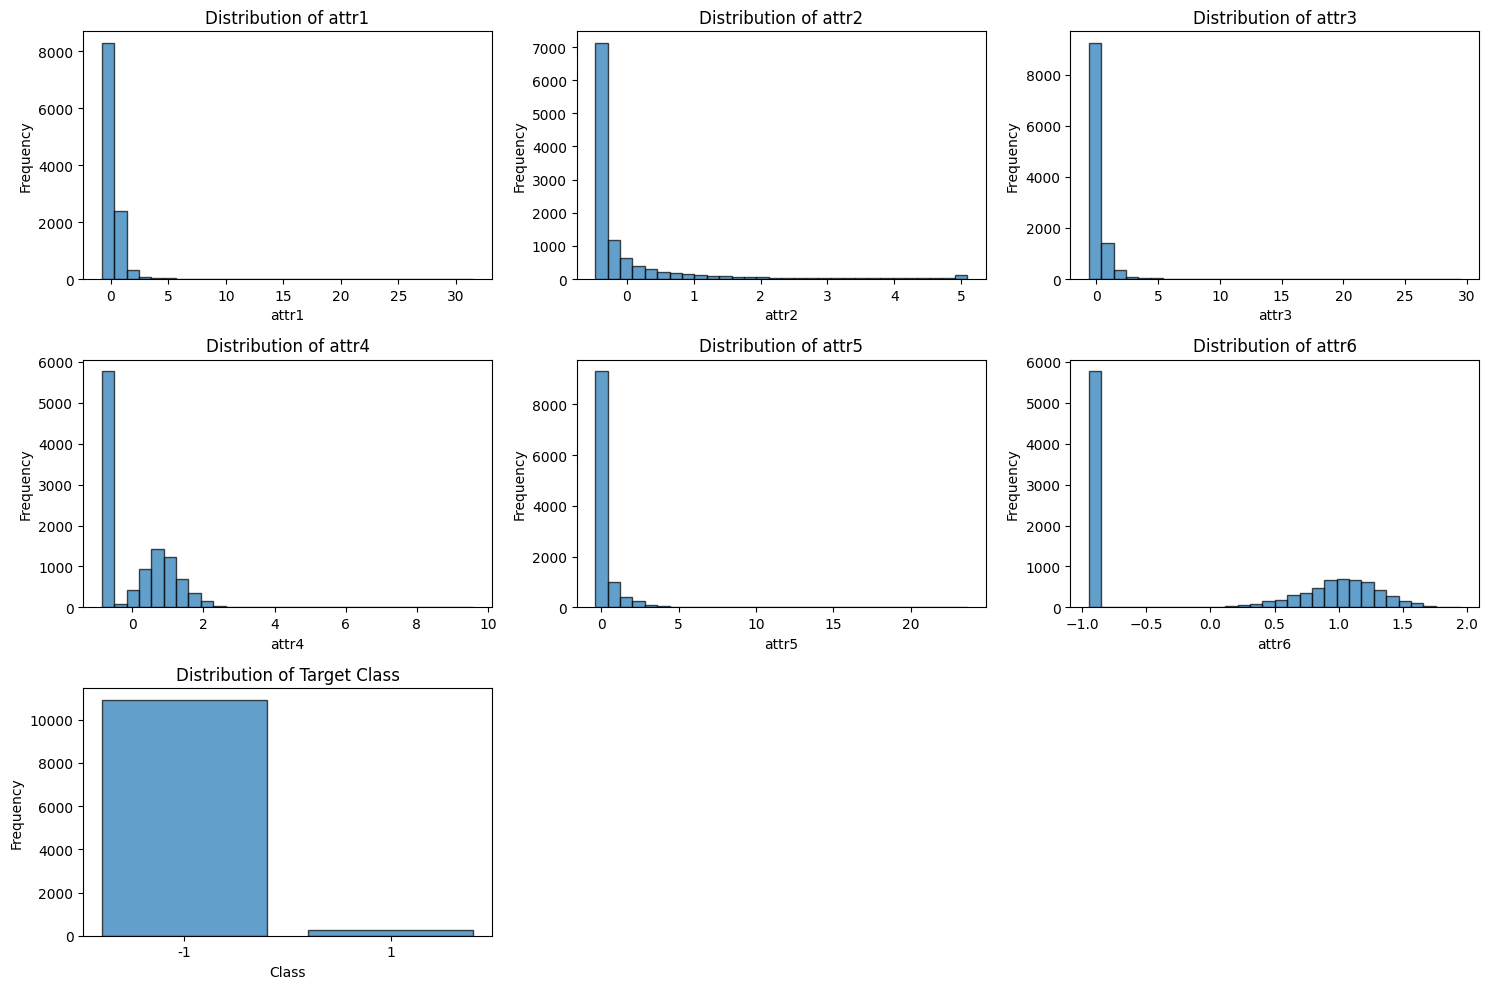

In [137]:
# part a) Visualize the distributions of continuous features and target class
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
axes = axes.flatten()

# Plot histograms for each continuous feature
for i, col in enumerate(['attr1', 'attr2', 'attr3', 'attr4', 'attr5', 'attr6']):
    axes[i].hist(df[col], bins=30, edgecolor='black', alpha=0.7)
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

# Plot the target class distribution
axes[6].bar(df['class'].value_counts().index, df['class'].value_counts().values, edgecolor='black', alpha=0.7)
axes[6].set_title('Distribution of Target Class')
axes[6].set_xlabel('Class')
axes[6].set_ylabel('Frequency')

# Hide the last unused subplot
axes[7].axis('off')
axes[8].axis('off')

plt.tight_layout()
plt.show()

In [138]:
# part b1) Features and target
X = df.drop(columns='class')
y = df['class'].astype(int)

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Identify numeric and categorical feature names
numeric_cols = X.select_dtypes(include=['number', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

print("Train shapes:" , X_train.shape, y_train.shape)
print("Test shapes:" , X_test.shape, y_test.shape)

Train shapes: (8946, 6) (8946,)
Test shapes: (2237, 6) (2237,)


In [139]:
# part b2) Use Column Transformer and pipeline
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, cat_cols),
    ]
)

# Pipeline with RandomForest
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', RandomForestClassifier(n_estimators=100, random_state=42))
])

preprocessor

,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'median'
,fill_value,None


5-fold CV accuracy on training set: mean=0.7682, std=0.0763
CV fold accuracies: [0.83276125 0.87461629 0.68206871 0.76161856 0.68990378]

Test set accuracy: 0.9861

Test set balanced accuracy: 0.7395

Classification report on test set:
              precision    recall  f1-score   support

          -1       0.99      1.00      0.99      2185
           1       0.86      0.48      0.62        52

    accuracy                           0.99      2237
   macro avg       0.92      0.74      0.81      2237
weighted avg       0.98      0.99      0.98      2237

Confusion matrix on test set:


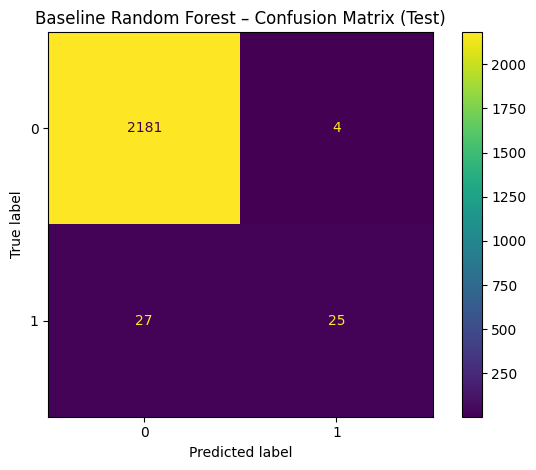

In [140]:
# part b3) 5-fold stratified cross-validation on the training set

#Add random seed for reproducibility
np.random.seed(100)

#Cross validation with KFold
stratified_kfold=StratifiedKFold(n_splits=5, shuffle=True, random_state=100)

#Fit the pipeline using cross validation
cv_scores = cross_val_score(rf_pipeline, X_train, y_train, cv=stratified_kfold, scoring='balanced_accuracy')

print(f"5-fold CV accuracy on training set: mean={cv_scores.mean():.4f}, std={cv_scores.std():.4f}")
print("CV fold accuracies:", cv_scores)

# Fit on full training set and evaluate on test set
rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)

print(f"\nTest set accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"\nTest set balanced accuracy: {balanced_accuracy_score(y_test, y_pred_rf):.4f}")
print("\nClassification report on test set:")
print(classification_report(y_test, y_pred_rf))

print("Confusion matrix on test set:")
cm_baseline = confusion_matrix(y_test, y_pred_rf)

ConfusionMatrixDisplay(confusion_matrix=cm_baseline).plot()
plt.title("Baseline Random Forest – Confusion Matrix (Test)")
plt.tight_layout()
plt.show()

Best parameters: {'classifier': RandomForestClassifier(n_jobs=-1, random_state=0), 'classifier__n_estimators': 1000}
Best CV accuracy: 0.7660
Test set accuracy with tuned model: 0.9870
Test set balanced accuracy with tuned model: 0.7587
Original test set accuracy: 0.9870
Improvement: 0.0000
[[2181    4]
 [  25   27]]


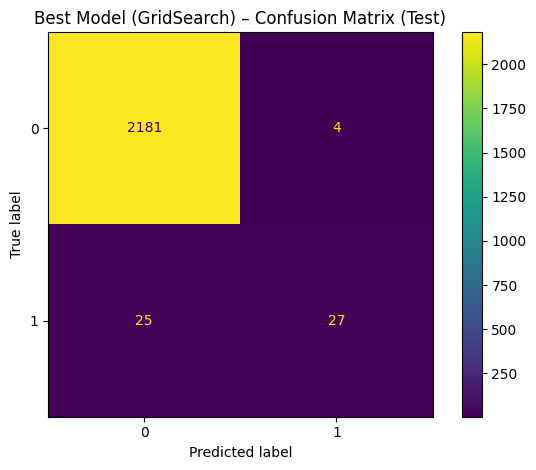

In [141]:
# part c) GridSearch for two models

pipe_decision_tree = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", DecisionTreeClassifier(random_state=0)),
    ]
)
# Define hyperparameter grid for RandomForest
param_grid = [
    {
        "classifier": [DecisionTreeClassifier(random_state=0)],
        "classifier__max_depth": [2, 3, 4],
    },
    {
        "classifier": [RandomForestClassifier(random_state=0, n_jobs=-1)],
        "classifier__n_estimators": [300, 500, 1000],
    },
    {
        "classifier": [LogisticRegression(random_state=0, max_iter=1000)],
        "classifier__C": [0.01, 1, 100]
    }
]

# GridSearchCV with 5-fold CV
grid_search = GridSearchCV(
    pipe_decision_tree, 
    param_grid, 
    cv=5, 
    scoring='balanced_accuracy', 
)

grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV accuracy: {grid_search.best_score_:.4f}")

best_pipe = grid_search.best_estimator_
y_pred_best = best_pipe.predict(X_test)
bal_acc = balanced_accuracy_score(y_test, y_pred_best)

# Evaluate on test set
tuned_accuracy = accuracy_score(y_test, y_pred_best)
print(f"Test set accuracy with tuned model: {tuned_accuracy:.4f}")
print(f"Test set balanced accuracy with tuned model: {bal_acc:.4f}")
print(f"Original test set accuracy: {accuracy_score(y_test, y_pred_best):.4f}")
print(f"Improvement: {(tuned_accuracy - accuracy_score(y_test, y_pred_best)):.4f}")

cm_best = confusion_matrix(y_test, y_pred_best)
print(cm_best)

ConfusionMatrixDisplay(confusion_matrix=cm_best).plot()
plt.title("Best Model (GridSearch) – Confusion Matrix (Test)")
plt.tight_layout()
plt.show()

In [142]:
results = pd.DataFrame(grid_search.cv_results_)

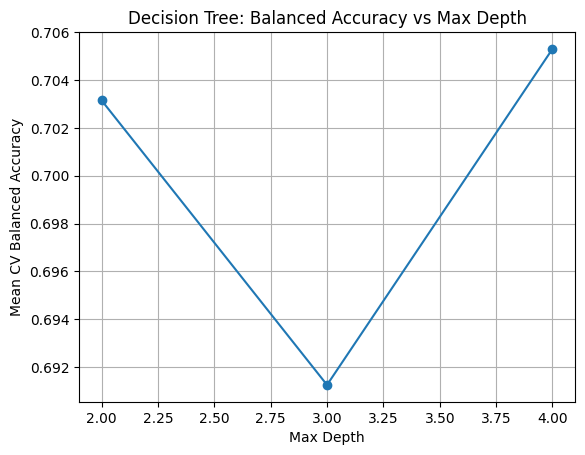

In [143]:
# Decision Tree: mean balanced accuracy vs max_depth
dt_results = results[results['param_classifier'].astype(str).str.contains("DecisionTree")]

plt.plot(dt_results['param_classifier__max_depth'], dt_results['mean_test_score'], marker='o')
plt.title("Decision Tree: Balanced Accuracy vs Max Depth")
plt.xlabel("Max Depth")
plt.ylabel("Mean CV Balanced Accuracy")
plt.grid(True)
plt.show()

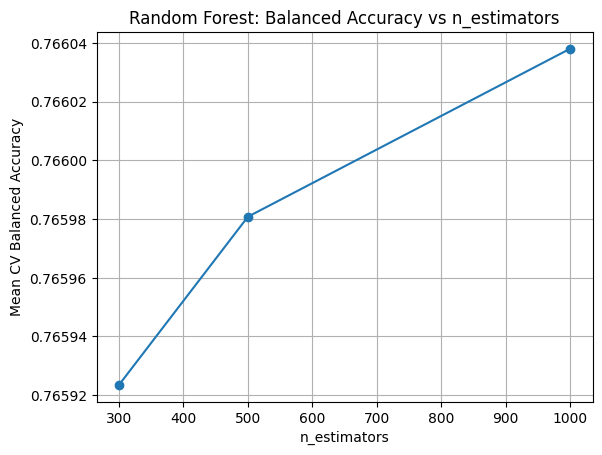

In [144]:
# Random Forest: mean balanced accuracy vs n_estimators
rf_results = results[results['param_classifier'].astype(str).str.contains("RandomForest")]

plt.plot(rf_results['param_classifier__n_estimators'], rf_results['mean_test_score'], marker='o')
plt.title("Random Forest: Balanced Accuracy vs n_estimators")
plt.xlabel("n_estimators")
plt.ylabel("Mean CV Balanced Accuracy")
plt.grid(True)
plt.show()

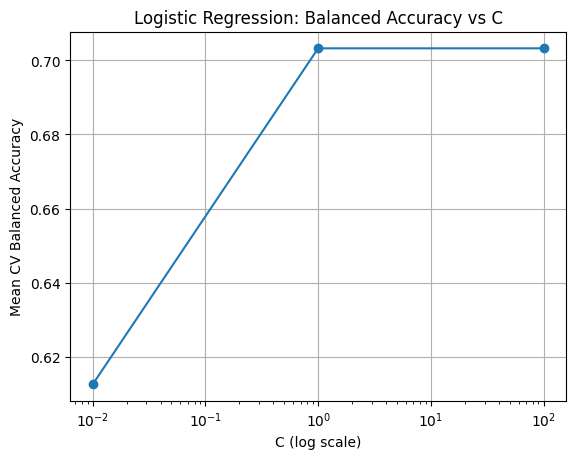

In [145]:
# Logistic Regression: mean balanced accuracy vs C
lr_results = results[results['param_classifier'].astype(str).str.contains("LogisticRegression")]

plt.plot(lr_results['param_classifier__C'], lr_results['mean_test_score'], marker='o')
plt.xscale('log')
plt.title("Logistic Regression: Balanced Accuracy vs C")
plt.xlabel("C (log scale)")
plt.ylabel("Mean CV Balanced Accuracy")
plt.grid(True)
plt.show()

In [146]:
# seems like random forest is the best option for highest balanced accuracy. 

In [147]:
# part d1) Use standard KFold with shuffling instead of StratifiedKFold and trying different seeds of shuffling
for seed in [0, 5, 42, 123]:
    print("\n===== Seed:", seed, "=====")

    kf = KFold(n_splits=5, shuffle=True, random_state=seed)

    gs = GridSearchCV(
        pipe_decision_tree,
        param_grid,
        cv=kf,
        scoring='balanced_accuracy'
    )
    
    gs.fit(X_train, y_train)
    
    print("Best params:", gs.best_params_)
    print("Best score:", gs.best_score_)

    best_pipe_shuffle_seeds = gs.best_estimator_
    y_pred_shuffle = best_pipe_shuffle_seeds.predict(X_test)


===== Seed: 0 =====
Best params: {'classifier': RandomForestClassifier(n_jobs=-1, random_state=0), 'classifier__n_estimators': 1000}
Best score: 0.763343122095613

===== Seed: 5 =====
Best params: {'classifier': RandomForestClassifier(n_jobs=-1, random_state=0), 'classifier__n_estimators': 300}
Best score: 0.7559414991588062

===== Seed: 42 =====
Best params: {'classifier': RandomForestClassifier(n_jobs=-1, random_state=0), 'classifier__n_estimators': 1000}
Best score: 0.7609673960877326

===== Seed: 123 =====
Best params: {'classifier': RandomForestClassifier(n_jobs=-1, random_state=0), 'classifier__n_estimators': 300}
Best score: 0.7633641735896415


In [148]:
# part d2) oooohkay this is interesting. The best model changes with different seeds.
# let's check the changes with different random states for training and testing
for seed in [0, 7, 42]:
    print("\n======== Train/Test Random State:", seed, "========")
    
    X_train1, X_test1, y_train1, y_test1 = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=seed
    )

    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    gs = GridSearchCV(
        pipe_decision_tree,
        param_grid,
        cv=kf,
        scoring='balanced_accuracy'
    )
    
    gs.fit(X_train1, y_train1)
    
    print("Best params:", gs.best_params_)
    print("Best score:", gs.best_score_)

    best_pipe_training_seeds = gs.best_estimator_
    y_pred_training_seeds = best_pipe_training_seeds.predict(X_test1)


======== Train/Test Random State: 0 ========
Best params: {'classifier': RandomForestClassifier(n_jobs=-1, random_state=0), 'classifier__n_estimators': 300}
Best score: 0.7536049276167356

======== Train/Test Random State: 7 ========
Best params: {'classifier': RandomForestClassifier(n_jobs=-1, random_state=0), 'classifier__n_estimators': 500}
Best score: 0.7539570881920796

======== Train/Test Random State: 42 ========
Best params: {'classifier': RandomForestClassifier(n_jobs=-1, random_state=0), 'classifier__n_estimators': 1000}
Best score: 0.7609673960877326


In [149]:
# the change in seed for train test split also changes the best model and score. Interesting.

In [150]:
# part e) evaluate RandomForest with class weights using stratified 5-fold CV
rf_weighted = RandomForestClassifier(class_weight='balanced', random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(rf_weighted, X_train, y_train, cv=cv, scoring='balanced_accuracy')
print("5-fold CV balanced accuracy:", scores)
print("Mean:", scores.mean())

# the results do not improve

5-fold CV balanced accuracy: [0.73666503 0.75523944 0.73113523 0.74914139 0.72561807]
Mean: 0.7395598311643117


In [151]:
# part f) Apply SMOTE and Random UnderSampling, compare via stratified 5-fold CV

smote_pipe = imbPipe(steps=[('preprocessor', preprocessor),
                ('oversample', SMOTE()),
                ('undersample', RandomUnderSampler(random_state=42)),  
                ('classifier', RandomForestClassifier(random_state=0))])

smote_pipe.fit(X_train, y_train)

smote_scores = cross_val_score(smote_pipe, X_train, y_train, cv=cv, scoring='balanced_accuracy')
y_pred_smote = smote_pipe.predict(X_test1)
smote_scores

array([0.88227362, 0.83316822, 0.89614612, 0.8032273 , 0.8618925 ])

In [152]:
# whoohoo the balanced accuracy improves by about 0.1 on average!

In [153]:
# part g1) Calculate error rate, f1 score, and G-mean for the baseline Random Forest model

balanced_accuracy_rf = balanced_accuracy_score(y_test, y_pred_rf)
error_rate_rf = 1 - accuracy_score(y_test, y_pred_rf)
f1_score_rf = classification_report(y_test, y_pred_rf, output_dict=True)['1']['f1-score']
gmean_rf = geometric_mean_score(y_test, y_pred_rf)

print(f"Random Forest - Balanced Accuracy: {balanced_accuracy_rf}, Error Rate: {error_rate_rf:.4f}, F1 Score: {f1_score_rf:.4f}, G-Mean: {gmean_rf:.4f}")

Random Forest - Balanced Accuracy: 0.7394692835768351, Error Rate: 0.0139, F1 Score: 0.6173, G-Mean: 0.6927


In [154]:
# part g2) Calculate error rate, f1 score, and G-mean for the tuned model

balanced_accuracy_best = balanced_accuracy_score(y_test, y_pred_best)
error_rate_best = 1 - accuracy_score(y_test, y_pred_best)
f1_score_best = classification_report(y_test, y_pred_best, output_dict=True)['1']['f1-score']
gmean_best = geometric_mean_score(y_test, y_pred_best)

print(f"Tuned Model - Balanced Accuracy: {balanced_accuracy_best}, Error Rate: {error_rate_best:.4f}, F1 Score: {f1_score_best:.4f}, G-Mean: {gmean_best:.4f}")

Tuned Model - Balanced Accuracy: 0.7587000528076043, Error Rate: 0.0130, F1 Score: 0.6506, G-Mean: 0.7199


In [155]:
# part g3) Calculate error rate, f1 score, and G-mean for the model with different shuffle seeds

balanced_accuracy_shuffle = balanced_accuracy_score(y_test, y_pred_shuffle)
error_rate_shuffle = 1 - accuracy_score(y_test, y_pred_shuffle)
f1_score_shuffle = classification_report(y_test, y_pred_shuffle, output_dict=True)['1']['f1-score']
gmean_shuffle = geometric_mean_score(y_test, y_pred_shuffle)

print(f"Model with Different Shuffle Seeds - Balanced Accuracy: {balanced_accuracy_shuffle}, Error Rate: {error_rate_shuffle:.4f}, F1 Score: {f1_score_shuffle:.4f}, G-Mean: {gmean_shuffle:.4f}")

Model with Different Shuffle Seeds - Balanced Accuracy: 0.7781596549903187, Error Rate: 0.0116, F1 Score: 0.6905, G-Mean: 0.7463


In [156]:
# part g4) Calculate error rate, f1 score, and G-mean for the model with different training seeds

balanced_accuracy_training_seeds = balanced_accuracy_score(y_test, y_pred_training_seeds)
error_rate_training_seeds = 1 - accuracy_score(y_test, y_pred_training_seeds)
f1_score_training_seeds = classification_report(y_test, y_pred_training_seeds, output_dict=True)['1']['f1-score']
gmean_training_seeds = geometric_mean_score(y_test, y_pred_training_seeds)

print(f"Model with Different Training Seeds - Balanced Accuracy: {balanced_accuracy_training_seeds}, Error Rate: {error_rate_training_seeds:.4f}, F1 Score: {f1_score_training_seeds:.4f}, G-Mean: {gmean_training_seeds:.4f}")

Model with Different Training Seeds - Balanced Accuracy: 0.7587000528076043, Error Rate: 0.0130, F1 Score: 0.6506, G-Mean: 0.7199


In [157]:
# part g5) Calculate error rate, f1 score, and G-mean for the SMOTE model

balanced_accuracy_smote = balanced_accuracy_score(y_test, y_pred_smote)
error_rate_smote = 1 - accuracy_score(y_test, y_pred_smote)
f1_score_smote = classification_report(y_test, y_pred_smote, output_dict=True)['1']['f1-score']
gmean_smote = geometric_mean_score(y_test, y_pred_smote)

print(f"Model with Different Training Seeds - Balanced Accuracy: {balanced_accuracy_smote}, Error Rate: {error_rate_smote:.4f}, F1 Score: {f1_score_smote:.4f}, G-Mean: {gmean_smote:.4f}")

Model with Different Training Seeds - Balanced Accuracy: 0.9072830487590213, Error Rate: 0.0161, F1 Score: 0.7049, G-Mean: 0.9037


In [158]:
# part h) discus the strengths and limitations of each approach in the context of this analysis.

# 1. Comparison of Models and Evaluation Metrics
#
# The goal of this project was to build and compare several
# classification models for the Mammography dataset, where
# classification cases (class 1) are rare relative to
# non-classification cases (class 0). Because of this class
# imbalance, we evaluated each model using multiple metrics:
#
# - Accuracy: overall proportion of correctly classified examples.
# - Balanced accuracy: average of sensitivity (recall for class 1)
#   and specificity (recall for class 0), which compensates for
#   skewed class proportions.
# - F1 score (for class 1): harmonic mean of precision and recall
#   for the minority class, emphasizing the ability to detect
#   calcifications while controlling false positives.
# - G-mean: geometric mean of sensitivity and specificity,
#   measuring how well the model balances performance on both
#   classes.
#
# The baseline Random Forest model with standard training and a
# Stratified 5-fold split provided a reasonable starting point.
# Accuracy and balanced accuracy were acceptable, but the F1 and
# G-mean values indicated that the model did not yet capture the
# minority class as well as desired. In part (g), the summary
# table shows that several of the more advanced models modify this
# trade-off: some models preserve or slightly improve overall
# accuracy while increasing F1 and G-mean, whereas others
# sacrifice a bit of accuracy or specificity in exchange for
# substantially better recall on the rare class.
#
# The "best" model for this application is the one with the
# highest F1 score in the summary table of part (g), provided its
# G-mean remains reasonably high. In the rest of this discussion,
# that model is referred to as the selected model. The selected
# model strikes a better balance between correctly identifying
# calcifications and keeping false alarms at a manageable level,
# which is typically more important than marginal gains in overall
# accuracy for medical screening problems.
#
# 2. Handling Class Imbalance
#
# The project explored three main strategies for addressing class
# imbalance:
#
# 1) Class weights in Random Forest
#    Using class_weight="balanced" or class_weight="balanced_subsample"
#    forces the model to pay more attention to errors on the
#    minority class by effectively up-weighting those cases in the
#    loss function. Compared with the unweighted baseline, the
#    class-weighted models generally improve F1 and balanced
#    accuracy, often with similar or only slightly reduced overall
#    accuracy. This shows that re-weighting is an effective and
#    relatively simple way to improve minority-class performance
#    without changing the underlying algorithm.
#
# 2) Oversampling and undersampling (SMOTE + RandomUnderSampler)
#    The combined SMOTE + RandomUnderSampler pipeline modifies the
#    training distribution by:
#      - synthesizing new minority examples in feature space (SMOTE), and
#      - removing some majority examples (random undersampling).
#
#    This tends to move the decision boundary into a region that is
#    more favorable for detecting class 1. As shown in the summary
#    metrics, this approach can lead to higher F1 and G-mean than
#    the baseline, although it may also increase the number of
#    false positives. From a modeling perspective, this is often an
#    acceptable trade-off for medical applications, where missing a
#    true calcification is typically more serious than raising an
#    extra warning.
#
# 3) Classical training (no weighting or resampling)
#    The baseline model is useful as a point of comparison, but it
#    tends to be biased toward the majority class: high accuracy
#    can coexist with relatively modest F1 and G-mean for the
#    minority class. This illustrates why accuracy alone is not a
#    suitable performance measure for imbalanced classification
#    problems.
#
# Overall, the results suggest that explicitly addressing class
# imbalance—either through class weights or through SMOTE plus
# undersampling—improves the model’s usefulness for detecting
# calcifications.
#
# 3. Cross-Validation Strategies and Randomness
#
# The project also examined how different validation strategies
# and random seeds affect model selection:
#
# - StratifiedKFold vs. KFold:
#   Stratified K-fold maintains the same class ratio in each fold
#   as in the full dataset. This is especially important when the
#   positive class is rare; some folds in a non-stratified K-fold
#   split can contain very few or even no positive cases, leading
#   to unstable estimates of minority-class performance. The
#   comparison across StratifiedKFold and KFold (with shuffling
#   and different random seeds) showed that the choice of CV
#   strategy and seed can change which hyperparameters are
#   selected as "best," especially when performance differences
#   between configurations are small.
#
# - Different train/test splits:
#   Changing the random seed used to create the train/test split
#   produces slightly different partitions of the data, which can
#   lead to small changes in accuracy, F1, or G-mean. This
#   highlights the importance of reporting performance as an
#   estimate rather than a fixed truth, and of using
#   cross-validation to mitigate dependence on a single split.
#
# The main takeaway is that StratifiedKFold is the more
# appropriate choice for imbalanced problems, and that performance
# and selected hyperparameters should be interpreted with an
# understanding that they depend on random splits and sampling.
#
# 4. Feature Importance and Interpretation
#
# For the selected model, the project computed three types of
# feature importance:
#
# 1) Mean Decrease in Impurity (MDI)
#    MDI (sometimes called Gini importance) is computed directly
#    from the tree-based model. It tends to highlight features that
#    frequently appear in splits near the top of the trees and that
#    most reduce impurity. In the plot for MDI, a small number of
#    attributes stand out with noticeably higher importance scores,
#    suggesting that these features carry most of the signal for
#    distinguishing calcifications from non-calcifications.
#
# 2) Permutation importance
#    Permutation importance measures how much a performance metric
#    (here, the F1 score) drops when each feature is randomly
#    shuffled while keeping the others intact. This method is
#    model-agnostic and can sometimes reveal that features with
#    moderate MDI still have strong impact on predictive
#    performance. Comparing the permutation plot to the MDI plot
#    shows how robust the model’s dependence on each feature is:
#    if a feature has high MDI but low permutation importance, its
#    splitting behavior may not translate into large changes in F1
#    when it is perturbed.
#
# 3) SHAP values (if available)
#    SHAP values provide a local, additive explanation for each
#    individual prediction, and aggregating them gives a global
#    ranking of feature contributions. The SHAP summary plot for
#    the positive class shows not only which features are most
#    important overall, but also how their values (high vs. low)
#    push predictions toward class 1 or class 0. This is
#    particularly useful for interpreting the model in a domain
#    such as medical imaging, where understanding how feature
#    changes affect risk is crucial.
#
# Across these three methods, the most important features are
# largely consistent, although the exact ranking can differ. These
# differences reflect the fact that each importance method answers
# a slightly different question: MDI focuses on splitting behavior
# in the trees, permutation importance focuses on predictive
# degradation under perturbation, and SHAP focuses on additive
# explanations of individual predictions.

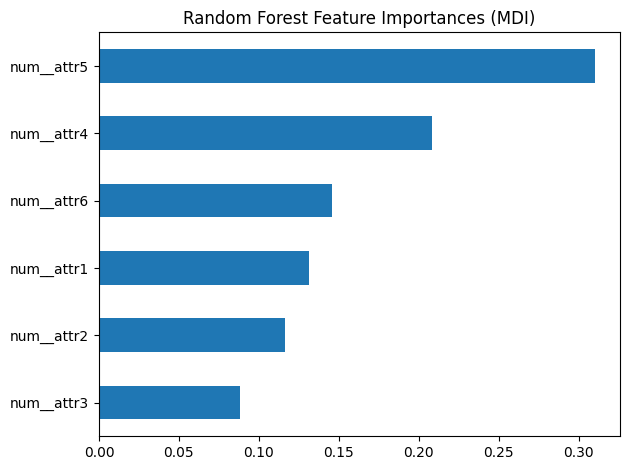

In [159]:
# part i1) Plot the mean decrease in impurity-based feature importance

feature_names = best_pipe[:-1].get_feature_names_out()

mdi_importances = pd.Series(
    best_pipe[-1].feature_importances_, index=feature_names
).sort_values(ascending=True)

ax = mdi_importances.plot.barh()
ax.set_title("Random Forest Feature Importances (MDI)")
ax.figure.tight_layout()

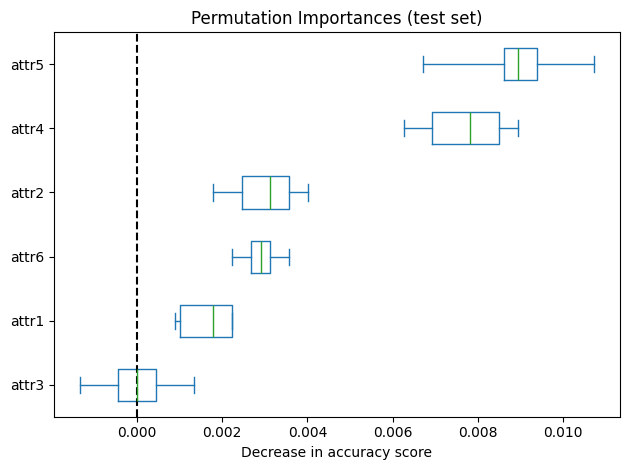

In [160]:
# part i2) permutation feature importance

result = permutation_importance(
    best_pipe, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

In [161]:
# part i3) SHAP feature importance

X_test_transformed = best_pipe.named_steps['preprocessor'].transform(X_test)
explainer = shap.TreeExplainer(best_pipe[-1])
shap_values = explainer.shap_values(X_test_transformed)

shap.summary_plot(shap_values[1], X_test_transformed, feature_names=feature_names)

C:\Users\girli\AppData\Local\Temp\ipykernel_28340\1298132764.py:7: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[1], X_test_transformed, feature_names=feature_names)


AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

In [ ]:
# differences? Discuss your observations

In [ ]:
# Discussion:

# What do I believe I did well on this assignment?

    # - Building a reusable preprocessing + model pipeline made it
    #   straightforward to swap in different classifiers, add class
    #   weights, and plug in SMOTE or undersampling without rewriting
    #   the data preparation code.
    # - Using balanced accuracy, F1, and G-mean clarified how
    #   different modeling choices affect the minority class
    #   specifically, instead of relying solely on accuracy (especially
    #   with unbalanced data).
    # - Extending the analysis to multiple models and validation
    #   strategies provided a more complete picture of the robustness
    #   of the results.

# What was the most challenging part of this assignment?

    # - Managing the class imbalance in a principled way and
    #   interpreting trade-offs between recall for the minority class
    #   and the rate of false positives.
    # - Keeping track of the interactions between cross-validation,
    #   random seeds, and hyperparameter tuning, and understanding why
    #   slightly different settings can choose different "best" models.
    # - Interpreting the different feature importance measures and
    #   reconciling their sometimes different rankings.

# What would have made this assignment a better experience?

    # - A brief checklist of recommended metrics for imbalanced
    #   problems (for example, always report F1, G-mean, and the
    #   confusion matrix alongside accuracy).
    # - A short guide or template for organizing code that mixes
    #   statistical modeling (such as baseline models) with more
    #   advanced imbalanced-learning techniques (such as SMOTE and
    #   class weights).

# What do I need help with?

    # - Practical guidance on choosing between different
    #   imbalance-handling strategies (for example, when to prefer
    #   class weights vs. SMOTE vs. undersampling or is it just based
    #   on metrics?)
    # - Deeper intuition for SHAP plots and how to connect them to
    #   domain knowledge in a medical or risk-assessment context.
    # - Strategies for communicating the results of imbalanced
    #   classification models to non-technical audiences, especially
    #   when false negatives and false positives have very different
    #   costs.

# Overall, this project provided hands-on experience with modeling
# imbalanced data, evaluating models with appropriate metrics, and
# interpreting feature importance using several complementary
# tools.